#### Model v2 -- to run code below I had to switch into a different virtual environment and install just these packages

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from skimage.filters import gabor_kernel
import copy
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import modeling

## do 16 16 
### do percent change in accuracy instead of accuracy differences 

In [2]:
transform_cifar = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64

## Load CIFAR-10 dataset (training = 50,000 images, test = 10,000 images)

cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
cifar_trainset, cifar_valset = random_split(cifar_trainset, [int(len(cifar_trainset) * 0.9), int(len(cifar_trainset) * 0.1)])
cifar_train_loader = DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)    # shape = (40000, 1, 32, 32)
cifar_val_loader = DataLoader(cifar_valset, batch_size=batch_size, shuffle=False)
cifar_test_loader = DataLoader(cifar_testset, batch_size=batch_size, shuffle=False)

# gabor_trainset = modeling.GaborDataset(num_images=45000, img_size=32, orientations=10, frequencies=[0.08, 0.04], add_noise=True, noise_level=0.1)
# gabor_valset = modeling.GaborDataset(num_images=5000, img_size=32, orientations=10, frequencies=[0.08, 0.04], add_noise=True, noise_level=0.1)
# gabor_testset = modeling.GaborDataset(num_images=10000, img_size=32, orientations=10, frequencies=[0.08, 0.04], add_noise=True, noise_level=0.1)
gabor_trainset = modeling.GaborDatasetNoisy(
    num_images=45000,
    img_size=32,
    orientations=10,
    frequencies=[0.08, 0.04],
    noise_level=0.2,
    orientation_jitter=0.15,
    frequency_jitter=0.015,
    sigma_range=(8, 22),
    offset_jitter=7,
    seed=1,
)
gabor_valset = modeling.GaborDatasetNoisy(
    num_images=5000,
    img_size=32,
    orientations=10,
    frequencies=[0.08, 0.04],
    noise_level=0.2,
    orientation_jitter=0.15,
    frequency_jitter=0.015,
    sigma_range=(8, 22),
    offset_jitter=7,
    seed=2,
)
gabor_testset = modeling.GaborDatasetNoisy(
    num_images=10000,
    img_size=32,
    orientations=10,
    frequencies=[0.08, 0.04],
    noise_level=0.2,
    orientation_jitter=0.15,
    frequency_jitter=0.015,
    sigma_range=(8, 22),
    offset_jitter=7,
    seed=3,
)
gabor_train_loader = DataLoader(gabor_trainset, batch_size=batch_size, shuffle=True)
gabor_val_loader = DataLoader(gabor_valset, batch_size=batch_size, shuffle=False)
gabor_test_loader = DataLoader(gabor_testset, batch_size=batch_size, shuffle=False)

assert len(cifar_trainset) + len(cifar_valset) == 50000
assert len(gabor_trainset) == len(cifar_trainset)
assert len(gabor_valset) == len(cifar_valset)
assert len(gabor_testset) == len(cifar_testset)

combined_trainset = ConcatDataset([cifar_trainset, gabor_trainset])
combined_loader = DataLoader(combined_trainset, batch_size=batch_size, shuffle=True)
combined_valset = ConcatDataset([cifar_valset, gabor_valset])
combined_val_loader = DataLoader(combined_valset, batch_size=batch_size, shuffle=True) # need to shuffle val set too because of concatdataset

Files already downloaded and verified
Files already downloaded and verified


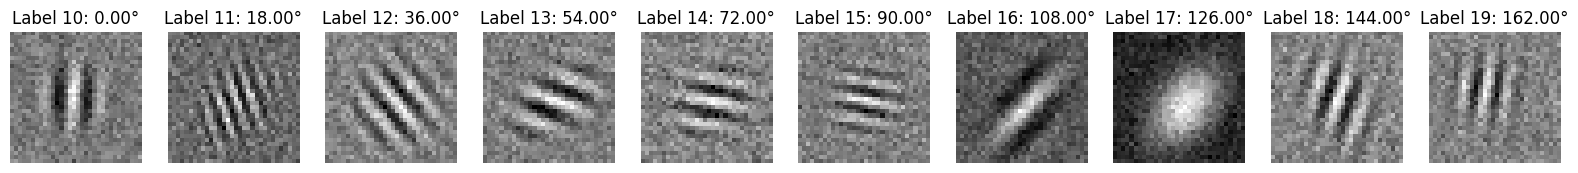

In [3]:
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
orientations = np.linspace(0, np.pi, 10, endpoint=False)
orientations_deg = orientations * 180 / np.pi
gabor_valset = modeling.GaborDatasetNoisy(
    num_images=10,
    img_size=32,
    orientations=10,
    frequencies=[0.08, 0.04],
    noise_level=0.15,
    orientation_jitter=0.1,
    frequency_jitter=0.015,
    sigma_range=(8, 22),
    offset_jitter=5,
    seed=43,
)

for i in range(10):
    axs[i].imshow(gabor_valset[i][0].squeeze(), cmap='gray')
    axs[i].set_title(f'Label {gabor_valset[i][1]}: {orientations_deg[gabor_valset[i][1] - 10]:.2f}°')
    axs[i].axis('off')



In [3]:
model = modeling.ConvNet_NoSkip(in_channels=1, height=32, width=32)
model, train_losses, val_losses, train_losses_epoch, val_losses_epoch, gabor_vals, cifar_vals = modeling.train_model(
    model, 
    train_loader=combined_loader,
    batch_size=64,
    probe_size=64,
    val_dataset=combined_valset,
    num_epochs=50,
    early_stopping=True,
    )

Training model with tag: 2025_10_23_09:56:19


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6071Validation Loss: 4.6074


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9876Validation Loss: 2.1049


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7932Validation Loss: 2.0291


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6786Validation Loss: 2.0233


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5799Validation Loss: 2.0038


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4773Validation Loss: 2.0037
Early stopping triggered: validation loss increased significantly 2.0037 -> 2.0686.


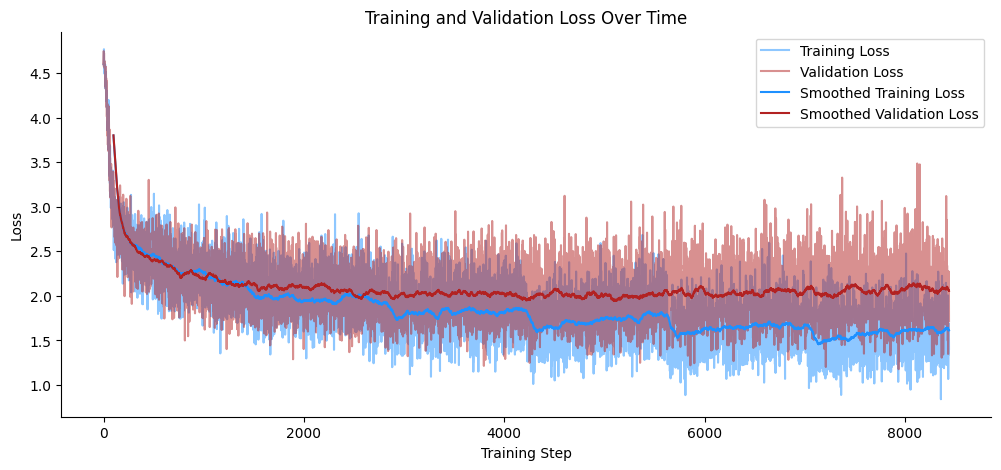

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train_losses, label="Training Loss", color='dodgerblue', alpha=0.5)
axs.plot(val_losses, label="Validation Loss", color='firebrick', alpha=0.5)

# plot smoothed losses
window_size = 100
train_losses_smooth = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
val_losses_smooth = np.convolve(val_losses, np.ones(window_size)/window_size, mode='valid')
axs.plot(range(window_size - 1, len(train_losses)), train_losses_smooth, label="Smoothed Training Loss", color='dodgerblue')
axs.plot(range(window_size - 1, len(val_losses)), val_losses_smooth, label="Smoothed Validation Loss", color='firebrick')
axs.set_xlabel("Training Step")
axs.set_ylabel("Loss")
axs.set_title("Training and Validation Loss Over Time")
axs.legend()
# axs.set_xlim(0, 10000)
plt.gca().spines[['top', 'right']].set_visible(False)


Text(0.5, 1.0, 'Validation Accuracy over Epochs')

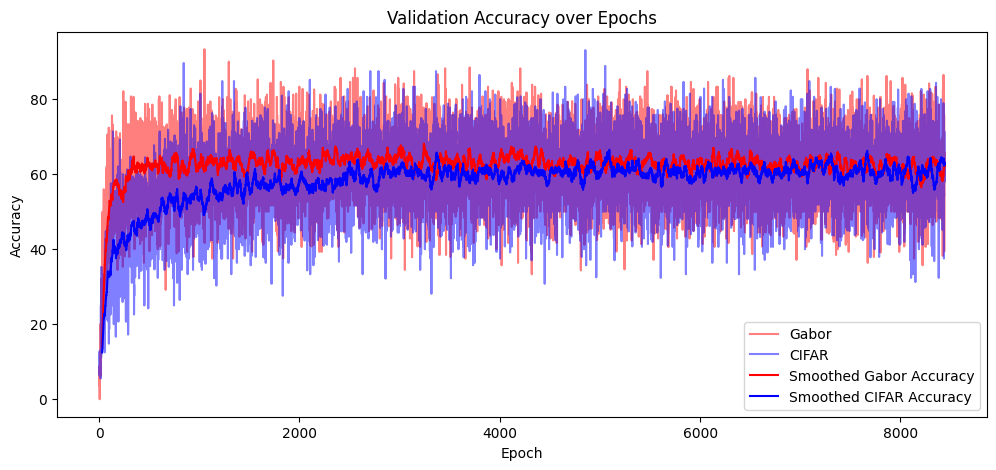

In [6]:
plt.figure(figsize=(12, 5))

plt.plot(gabor_vals, label='Gabor', color='red', alpha=0.5)
plt.plot(cifar_vals, label='CIFAR', color='blue', alpha=0.5)

# plot smoothed accuracies
window_size = 30
gabor_vals_smooth = np.convolve(gabor_vals, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size - 1, len(gabor_vals)), gabor_vals_smooth, label="Smoothed Gabor Accuracy", color='red')
cifar_vals_smooth = np.convolve(cifar_vals, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size - 1, len(cifar_vals)), cifar_vals_smooth, label="Smoothed CIFAR Accuracy", color='blue')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.xlim(-10, 200)
plt.title('Validation Accuracy over Epochs')

In [7]:
noise_results = {
    'noise_level': [],
    # 'noisy1_gabor_acc': [],
    # 'noisy1_cifar_acc': [],
    'noisy2_gabor_acc': [],
    'noisy2_cifar_acc': [],
}
noise_levels = np.arange(0, 1.05, 0.05)

for noise in noise_levels:
    # noisy_model = copy.deepcopy(model)

    # noisy_model.eval()
    # noisy_model.skip.noise_level = noise
    # noisy1_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
    # noisy1_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

    noisy_model = copy.deepcopy(model)
    noisy_model.eval()
    # noisy_model.skip.noise_level = 0
    noisy_middle_model = modeling.add_noise_to_middle_layer(noisy_model, noise_level=noise)
    noisy2_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
    noisy2_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

    noise_results['noise_level'].append(noise)
    # noise_results['noisy1_gabor_acc'].append(noisy1_gabor_acc)
    # noise_results['noisy1_cifar_acc'].append(noisy1_cifar_acc)
    noise_results['noisy2_gabor_acc'].append(noisy2_gabor_acc)
    noise_results['noisy2_cifar_acc'].append(noisy2_cifar_acc)


In [8]:
import pandas as pd
noise_results_df = pd.DataFrame(noise_results)
noise_results_df

,noise_level,noisy2_gabor_acc,noisy2_cifar_acc
0,0.00,62.35,59.13
1,0.05,61.03,57.52
2,0.10,59.17,53.90
3,0.15,52.81,25.86
4,0.20,53.06,35.93
5,0.25,33.45,14.30
6,0.30,29.10,23.63
7,0.35,23.61,23.82
8,0.40,28.67,14.16
9,0.45,30.89,19.28


In [9]:
# noise_results_df['noisy1_gabor_pctchange'] = (noise_results_df['noisy1_gabor_acc'] - noise_results_df['noisy1_gabor_acc'].iloc[0]) / noise_results_df['noisy1_gabor_acc'].iloc[0] * 100
noise_results_df['noisy2_gabor_pctchange'] = (noise_results_df['noisy2_gabor_acc'] - noise_results_df['noisy2_gabor_acc'].iloc[0]) / noise_results_df['noisy2_gabor_acc'].iloc[0] * 100
# noise_results_df['noisy1_cifar_pctchange'] = (noise_results_df['noisy1_cifar_acc'] - noise_results_df['noisy1_cifar_acc'].iloc[0]) / noise_results_df['noisy1_cifar_acc'].iloc[0] * 100
noise_results_df['noisy2_cifar_pctchange'] = (noise_results_df['noisy2_cifar_acc'] - noise_results_df['noisy2_cifar_acc'].iloc[0]) / noise_results_df['noisy2_cifar_acc'].iloc[0] * 100

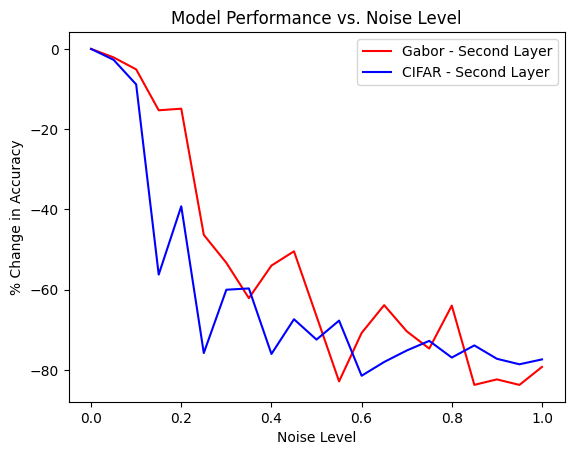

In [10]:
import seaborn as sns
# sns.lineplot(data=noise_results_df, x='noise_level', y='noisy1_gabor_pctchange', label='Gabor - First Layer', color='red', linestyle='--')
# sns.lineplot(data=noise_results_df, x='noise_level', y='noisy1_cifar_pctchange', label='CIFAR - First Layer', color='blue', linestyle='--')

sns.lineplot(data=noise_results_df, x='noise_level', y='noisy2_gabor_pctchange', label='Gabor - Second Layer', color='red')
sns.lineplot(data=noise_results_df, x='noise_level', y='noisy2_cifar_pctchange', label='CIFAR - Second Layer', color='blue')

plt.xlabel('Noise Level')
plt.ylabel('% Change in Accuracy')
plt.title('Model Performance vs. Noise Level')
plt.legend()

In [11]:
#### stability plots ####
results = {
    'idx': [],
    'gabor_acc': [],
    'cifar_acc': [],
}

noise_results = {
    'idx': [],
    'noise_level': [],
    # 'noisy1_gabor_acc': [],
    # 'noisy1_cifar_acc': [],
    'noisy2_gabor_acc': [],
    'noisy2_cifar_acc': [],
}
noise_levels = np.arange(0, 1.05, 0.05)

for i in range(20):
    model = modeling.ConvNet_NoSkip(in_channels=1, height=32, width=32)
    model, losses, val_losses, _, _, _, _ = modeling.train_model(
        model, 
        combined_loader, 
        val_dataset=combined_valset, 
        batch_size=64, 
        probe_size=64, 
        num_epochs=50, 
        early_stopping=True
    )

    gabor_acc = modeling.evaluate_gabor_accuracy(model, gabor_test_loader)
    cifar_acc = modeling.evaluate_cifar_accuracy(model, cifar_test_loader)

    results['idx'].append(i)
    results['gabor_acc'].append(gabor_acc)
    results['cifar_acc'].append(cifar_acc)

    for noise in noise_levels:
        # noisy_model = copy.deepcopy(model)

        # noisy_model.eval()
        # noisy_model.skip.noise_level = noise
        # noisy_first_model = modeling.add_noise_to_first_layer(noisy_model, noise_level=noise)
        # noisy1_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
        # noisy1_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

        noisy_model = copy.deepcopy(model)
        noisy_model.eval()
        # noisy_model.skip.noise_level = 0
        noisy_middle_model = modeling.add_noise_to_middle_layer(noisy_model, noise_level=noise)
        noisy2_gabor_acc = modeling.evaluate_gabor_accuracy(noisy_model, gabor_test_loader)
        noisy2_cifar_acc = modeling.evaluate_cifar_accuracy(noisy_model, cifar_test_loader)

        noise_results['idx'].append(i)
        noise_results['noise_level'].append(noise)
        # noise_results['noisy1_gabor_acc'].append(noisy1_gabor_acc)
        # noise_results['noisy1_cifar_acc'].append(noisy1_cifar_acc)
        noise_results['noisy2_gabor_acc'].append(noisy2_gabor_acc)
        noise_results['noisy2_cifar_acc'].append(noisy2_cifar_acc)
    
    print(f'Iteration {i+1}/20 complete.')

Training model with tag: 2025_10_23_09:59:21


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6037Validation Loss: 4.6033


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0220Validation Loss: 2.1495


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8088Validation Loss: 2.0185


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6506Validation Loss: 1.9704
Early stopping triggered: validation loss increased significantly 1.9704 -> 2.0252.
Iteration 1/20 complete.
Training model with tag: 2025_10_23_10:00:32


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6075Validation Loss: 4.6086


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0430Validation Loss: 2.1600


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8235Validation Loss: 2.0421


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.7126Validation Loss: 2.0195


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.6033Validation Loss: 2.0184


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.5207Validation Loss: 2.0210


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.4581Validation Loss: 2.0691


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.3986Validation Loss: 2.0927


Batches in epoch #9:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [9/50]Training Loss: 1.3270Validation Loss: 2.1192


Batches in epoch #10:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [10/50]Training Loss: 1.2937Validation Loss: 2.1339
Early stopping triggered: validation loss increased significantly 2.1339 -> 2.1896.
Iteration 2/20 complete.
Training model with tag: 2025_10_23_10:03:04


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6094Validation Loss: 4.6091


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0026Validation Loss: 2.1385


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7691Validation Loss: 2.0245


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6418Validation Loss: 1.9928


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5192Validation Loss: 1.9649


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4480Validation Loss: 2.0043


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.3752Validation Loss: 2.0334
Early stopping triggered: validation loss increased significantly 2.0334 -> 2.1273.
Iteration 3/20 complete.
Training model with tag: 2025_10_23_10:04:55


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6133Validation Loss: 4.6139


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9808Validation Loss: 2.0968


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7608Validation Loss: 1.9949


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6500Validation Loss: 1.9845
Early stopping triggered: validation loss increased significantly 1.9845 -> 2.0400.
Iteration 4/20 complete.
Training model with tag: 2025_10_23_10:06:06


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6064Validation Loss: 4.6085


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.1040Validation Loss: 2.2229


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8152Validation Loss: 2.0363


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6946Validation Loss: 2.0274


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5954Validation Loss: 2.0367


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4753Validation Loss: 2.0430
Early stopping triggered: validation loss increased significantly 2.0430 -> 2.1143.
Iteration 5/20 complete.
Training model with tag: 2025_10_23_10:07:45


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6082Validation Loss: 4.6094


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9823Validation Loss: 2.1249


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7558Validation Loss: 2.0052


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6813Validation Loss: 2.0288


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5577Validation Loss: 2.0032


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4706Validation Loss: 2.0002


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.4013Validation Loss: 2.0433


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.3422Validation Loss: 2.0648
Early stopping triggered: validation loss increased significantly 2.0648 -> 2.1396.
Iteration 6/20 complete.
Training model with tag: 2025_10_23_10:09:50


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6052Validation Loss: 4.6056


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9718Validation Loss: 2.0869


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7715Validation Loss: 2.0181


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6424Validation Loss: 1.9902


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5254Validation Loss: 1.9712


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4688Validation Loss: 2.0116
Early stopping triggered: validation loss increased significantly 2.0116 -> 2.0618.
Iteration 7/20 complete.
Training model with tag: 2025_10_23_10:11:28


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6119Validation Loss: 4.6133


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0166Validation Loss: 2.1501


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8235Validation Loss: 2.0558


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6413Validation Loss: 1.9929


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5769Validation Loss: 2.0193


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.5068Validation Loss: 2.0260


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.4090Validation Loss: 2.0326


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.3291Validation Loss: 2.0608
Early stopping triggered: validation loss increased significantly 2.0608 -> 2.1256.
Iteration 8/20 complete.
Training model with tag: 2025_10_23_10:13:31


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6123Validation Loss: 4.6125


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0815Validation Loss: 2.2179


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7794Validation Loss: 2.0120


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6312Validation Loss: 1.9520


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5401Validation Loss: 1.9732


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4871Validation Loss: 1.9994


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.3824Validation Loss: 2.0151


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.3333Validation Loss: 2.0482
Early stopping triggered: validation loss increased significantly 2.0482 -> 2.1111.
Iteration 9/20 complete.
Training model with tag: 2025_10_23_10:15:35


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6068Validation Loss: 4.6077


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9708Validation Loss: 2.1136


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7526Validation Loss: 2.0010


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6161Validation Loss: 1.9613


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5173Validation Loss: 1.9892


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4326Validation Loss: 2.0179
Early stopping triggered: validation loss increased significantly 2.0179 -> 2.0761.
Iteration 10/20 complete.
Training model with tag: 2025_10_23_10:17:13


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6096Validation Loss: 4.6096


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0427Validation Loss: 2.1632


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8204Validation Loss: 2.0639


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6503Validation Loss: 1.9883


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5533Validation Loss: 1.9868


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4876Validation Loss: 2.0178


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.4300Validation Loss: 2.0667


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.3253Validation Loss: 2.0638


Batches in epoch #9:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [9/50]Training Loss: 1.2662Validation Loss: 2.1026
Early stopping triggered: validation loss increased significantly 2.1026 -> 2.1799.
Iteration 11/20 complete.
Training model with tag: 2025_10_23_10:19:31


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6076Validation Loss: 4.6075


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9681Validation Loss: 2.0873


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7733Validation Loss: 1.9938


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6583Validation Loss: 1.9809


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5531Validation Loss: 1.9532


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4811Validation Loss: 1.9505


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.3850Validation Loss: 1.9840


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.3332Validation Loss: 2.0151


Batches in epoch #9:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [9/50]Training Loss: 1.2818Validation Loss: 2.0598


Batches in epoch #10:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [10/50]Training Loss: 1.2543Validation Loss: 2.1095


Batches in epoch #11:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [11/50]Training Loss: 1.2055Validation Loss: 2.1583


Batches in epoch #12:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [12/50]Training Loss: 1.1648Validation Loss: 2.2007
Early stopping triggered: validation loss increased significantly 2.2007 -> 2.2723.
Iteration 12/20 complete.
Training model with tag: 2025_10_23_10:22:29


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6066Validation Loss: 4.6065


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0492Validation Loss: 2.1687


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7945Validation Loss: 2.0141


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6554Validation Loss: 1.9750


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5655Validation Loss: 1.9955


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4857Validation Loss: 2.0022


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.4030Validation Loss: 2.0380


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.3469Validation Loss: 2.0747


Batches in epoch #9:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [9/50]Training Loss: 1.2693Validation Loss: 2.0842
Early stopping triggered: validation loss increased significantly 2.0842 -> 2.1687.
Iteration 13/20 complete.
Training model with tag: 2025_10_23_10:24:46


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6087Validation Loss: 4.6077


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9588Validation Loss: 2.0810


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7875Validation Loss: 2.0120


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6446Validation Loss: 1.9720


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5728Validation Loss: 1.9780


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4906Validation Loss: 2.0210


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.4068Validation Loss: 2.0215


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.3273Validation Loss: 2.0318
Early stopping triggered: validation loss increased significantly 2.0318 -> 2.1074.
Iteration 14/20 complete.
Training model with tag: 2025_10_23_10:26:51


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6063Validation Loss: 4.6063


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0591Validation Loss: 2.1750


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8188Validation Loss: 2.0620


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6840Validation Loss: 2.0313


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5600Validation Loss: 2.0096


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4720Validation Loss: 2.0250


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.3956Validation Loss: 2.0469


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.3299Validation Loss: 2.0894
Early stopping triggered: validation loss increased significantly 2.0894 -> 2.1471.
Iteration 15/20 complete.
Training model with tag: 2025_10_23_10:28:55


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6134Validation Loss: 4.6117


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0623Validation Loss: 2.1753


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8045Validation Loss: 2.0311


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6731Validation Loss: 2.0083


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5779Validation Loss: 1.9924


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4814Validation Loss: 2.0015


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.4018Validation Loss: 2.0086


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.3408Validation Loss: 2.0482
Early stopping triggered: validation loss increased significantly 2.0482 -> 2.1058.
Iteration 16/20 complete.
Training model with tag: 2025_10_23_10:31:00


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6091Validation Loss: 4.6102


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0274Validation Loss: 2.1354


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8312Validation Loss: 2.0390


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.7089Validation Loss: 2.0023


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5780Validation Loss: 1.9557


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.5143Validation Loss: 1.9872


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.3994Validation Loss: 1.9741
Early stopping triggered: validation loss increased significantly 1.9741 -> 2.0354.
Iteration 17/20 complete.
Training model with tag: 2025_10_23_10:32:51


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6040Validation Loss: 4.6057


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0595Validation Loss: 2.1710


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.8432Validation Loss: 2.0705


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.7026Validation Loss: 2.0135


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.6203Validation Loss: 2.0205


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.5478Validation Loss: 2.0463


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.4534Validation Loss: 2.0339


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.4139Validation Loss: 2.0680


Batches in epoch #9:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [9/50]Training Loss: 1.3293Validation Loss: 2.0859
Early stopping triggered: validation loss increased significantly 2.0859 -> 2.1636.
Iteration 18/20 complete.
Training model with tag: 2025_10_23_10:35:09


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6030Validation Loss: 4.6032


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 1.9526Validation Loss: 2.0772


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7899Validation Loss: 2.0353


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.7166Validation Loss: 2.0624


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5627Validation Loss: 2.0128


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4525Validation Loss: 2.0203
Early stopping triggered: validation loss increased significantly 2.0203 -> 2.0775.
Iteration 19/20 complete.
Training model with tag: 2025_10_23_10:36:47


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches in epoch #1:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [1/50]Training Loss: 4.6083Validation Loss: 4.6060


Batches in epoch #2:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [2/50]Training Loss: 2.0355Validation Loss: 2.1624


Batches in epoch #3:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [3/50]Training Loss: 1.7907Validation Loss: 2.0202


Batches in epoch #4:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [4/50]Training Loss: 1.6250Validation Loss: 1.9756


Batches in epoch #5:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [5/50]Training Loss: 1.5612Validation Loss: 1.9993


Batches in epoch #6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [6/50]Training Loss: 1.4871Validation Loss: 2.0264


Batches in epoch #7:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [7/50]Training Loss: 1.4187Validation Loss: 2.0509


Batches in epoch #8:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [8/50]Training Loss: 1.3428Validation Loss: 2.0917


Batches in epoch #9:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [9/50]Training Loss: 1.2876Validation Loss: 2.1342


Batches in epoch #10:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch [10/50]Training Loss: 1.2755Validation Loss: 2.1739
Early stopping triggered: validation loss increased significantly 2.1739 -> 2.2341.
Iteration 20/20 complete.


In [12]:
import pandas as pd
noise_results_df = pd.DataFrame(noise_results)
noise_results_df

,idx,noise_level,noisy2_gabor_acc,noisy2_cifar_acc
0,0,0.00,62.26,59.05
1,0,0.05,60.76,55.58
2,0,0.10,54.68,39.60
3,0,0.15,33.76,23.43
4,0,0.20,29.15,16.57
...,...,...,...,...
415,19,0.80,15.80,16.48
416,19,0.85,11.24,15.42
417,19,0.90,15.48,10.01
418,19,0.95,14.10,13.74


(0.0, 63.36594257472844)

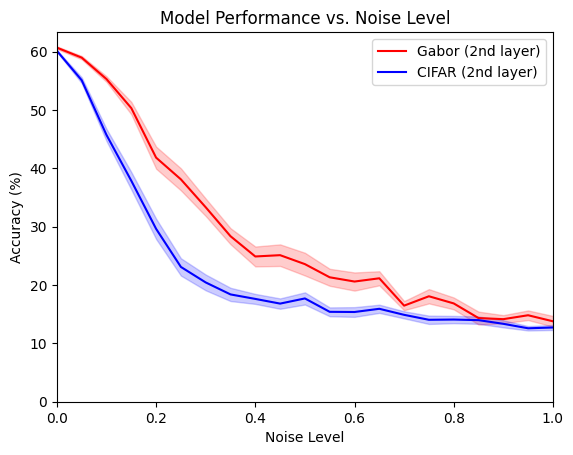

In [13]:
import seaborn as sns

# sns.lineplot(
#     data=noise_results_df, 
#     x='noise_level', 
#     y='noisy1_gabor_acc', 
#     err_style='band',
#     errorbar='se',
#     markers='o',
#     linestyle='--',
#     color='red',
#     label='Gabor (1st layer)'
#     )

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy2_gabor_acc', 
    err_style='band',
    errorbar='se',
    markers='o',
    color='red',
    label='Gabor (2nd layer)'
    )

# sns.lineplot(
#     data=noise_results_df, 
#     x='noise_level', 
#     y='noisy1_cifar_acc', 
#     err_style='band',
#     errorbar='se',
#     color='blue',
#     linestyle='--',
#     label='CIFAR (1st layer)'
#     )

sns.lineplot(
    data=noise_results_df, 
    x='noise_level', 
    y='noisy2_cifar_acc', 
    err_style='band',
    errorbar='se',
    color='blue',
    label='CIFAR (2nd layer)'
    )

plt.xlabel('Noise Level')
plt.ylabel('Accuracy (%)')
plt.title('Model Performance vs. Noise Level')
# plt.legend(['Gabor Accuracy', '', 'CIFAR Accuracy', ''])
plt.legend()
plt.xlim(0, 1)
plt.ylim(bottom=0)

In [14]:
pct_change_dfs = []

for i in range(10):
    temp_df = noise_results_df[noise_results_df['idx'] == i]
    # temp_df['noisy1_gabor_pctchange'] = (temp_df['noisy1_gabor_acc'] - temp_df['noisy1_gabor_acc'].iloc[0]) / temp_df['noisy1_gabor_acc'].iloc[0] * 100
    temp_df['noisy2_gabor_pctchange'] = (temp_df['noisy2_gabor_acc'] - temp_df['noisy2_gabor_acc'].iloc[0]) / temp_df['noisy2_gabor_acc'].iloc[0] * 100
    # temp_df['noisy1_cifar_pctchange'] = (temp_df['noisy1_cifar_acc'] - temp_df['noisy1_cifar_acc'].iloc[0]) / temp_df['noisy1_cifar_acc'].iloc[0] * 100
    temp_df['noisy2_cifar_pctchange'] = (temp_df['noisy2_cifar_acc'] - temp_df['noisy2_cifar_acc'].iloc[0]) / temp_df['noisy2_cifar_acc'].iloc[0] * 100

    pct_change_dfs.append(temp_df)

pct_change_df = pd.concat(pct_change_dfs)

/tmp/ipykernel_834566/1410086002.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['noisy2_gabor_pctchange'] = (temp_df['noisy2_gabor_acc'] - temp_df['noisy2_gabor_acc'].iloc[0]) / temp_df['noisy2_gabor_acc'].iloc[0] * 100
/tmp/ipykernel_834566/1410086002.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['noisy2_cifar_pctchange'] = (temp_df['noisy2_cifar_acc'] - temp_df['noisy2_cifar_acc'].iloc[0]) / temp_df['noisy2_cifar_acc'].iloc[0] * 100
/tmp/ipykernel_834566/1410086002.py:6: Setting

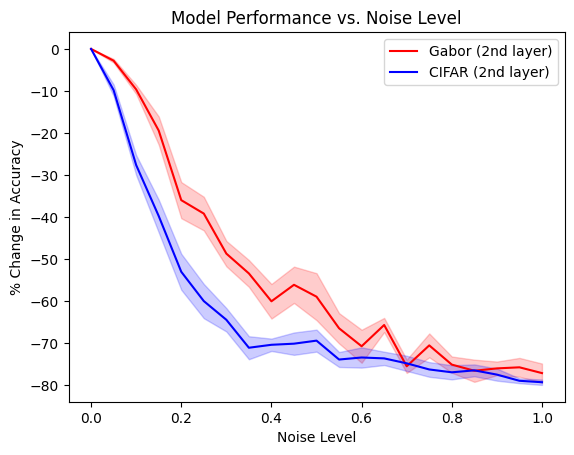

In [15]:
import seaborn as sns

# sns.lineplot(
#     data=pct_change_df, 
#     x='noise_level', 
#     y='noisy1_gabor_pctchange', 
#     err_style='band',
#     errorbar='se',
#     markers='o',
#     linestyle='--',
#     color='red',
#     label='Gabor (Skip connect)'
#     )

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy2_gabor_pctchange', 
    err_style='band',
    errorbar='se',
    markers='o',
    color='red',
    label='Gabor (2nd layer)'
    )

# sns.lineplot(
#     data=pct_change_df, 
#     x='noise_level', 
#     y='noisy1_cifar_pctchange', 
#     err_style='band',
#     errorbar='se',
#     color='blue',
#     linestyle='--',
#     label='CIFAR (Skip connect)'
#     )

sns.lineplot(
    data=pct_change_df, 
    x='noise_level', 
    y='noisy2_cifar_pctchange', 
    err_style='band',
    errorbar='se',
    color='blue',
    label='CIFAR (2nd layer)'
    )

plt.xlabel('Noise Level')
plt.ylabel('% Change in Accuracy')
plt.title('Model Performance vs. Noise Level')
# plt.legend(['Gabor Accuracy', '', 'CIFAR Accuracy', ''])
plt.legend()
# plt.xlim(0, 1)
# plt.ylim(bottom=-10)